## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If you didn't download it yet, please get the relevant file now!
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

/bin/bash: /home/giacomo/Programs/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2021-12-12 22:05:05--  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/xvjzaxzz3ysphme/data_000637.txt [following]
--2021-12-12 22:05:05--  https://www.dropbox.com/s/raw/xvjzaxzz3ysphme/data_000637.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc653cff27752781f689eb36c9d5.dl.dropboxusercontent.com/cd/0/inline/BbvvWH-joMBTx82wphKrgxsL4Y-FAIYitkMcBjYeij9Qno964UdeNt7gxClgppiX7MFDLb1ZayyRDBIuGfk9uAG-s2QUUZrQv1dA5uzfR9SSDiIrKJpn_UjtrjZaDu6mDirupS37ybpnIxbYL4q0GjEf/file# [following]
--2021-12-12 22:05:06--  https://uc653cff27752781f689eb36

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

3563
980200549.1666666 ns
29
           HEAD           FPGA    TDC_CHANNEL     ORBIT_CNT     BX_COUNTER  \
count  655694.0  655694.000000  655694.000000  6.556940e+05  655694.000000   
mean        1.0       0.295420      55.867771  3.869206e+09    1781.260411   
std         0.0       0.456232      39.040948  3.182270e+03    1027.445755   
min         1.0       0.000000       1.000000  3.869200e+09       0.000000   
25%         1.0       0.000000      26.000000  3.869203e+09     895.000000   
50%         1.0       0.000000      57.000000  3.869207e+09    1778.000000   
75%         1.0       1.000000      64.000000  3.869209e+09    2668.000000   
max         1.0       1.000000     139.000000  3.869211e+09    3563.000000   

            TDC_MEAS       TIME_NS  
count  655694.000000  6.556940e+05  
mean       13.311253  5.369845e+08  
std         9.202410  2.834605e+08  
min         0.000000  6.384833e+04  
25%         5.000000  2.926543e+08  
50%        13.000000  5.794779e+08  
75%      

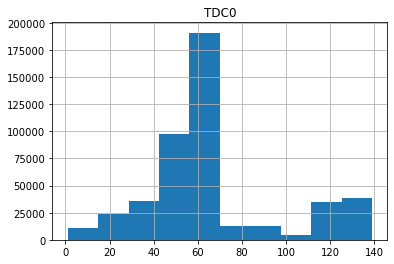

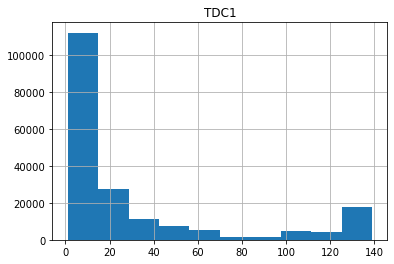

In [2]:
# 1.
import pandas as pd
import numpy as np

df = pd.read_csv('data/data_000637.txt') #, nrows=20000) # 1310720

# 2.
x = df.BX_COUNTER.max()
dt_ORBIT_CNT = 25 * x
print(x)

# 3.
tot_time = (df.ORBIT_CNT.max() - df.ORBIT_CNT.min()) * dt_ORBIT_CNT + \
            df.BX_COUNTER[df.ORBIT_CNT == df.ORBIT_CNT.max()].max() * 25 + \
            df.TDC_MEAS[df.ORBIT_CNT == df.ORBIT_CNT.max()].max() * 25 / 30
print(f'{tot_time} ns')
print(f'{df.TDC_MEAS.max()}')

# 4.
df['TIME_NS'] = (df.ORBIT_CNT - df.ORBIT_CNT.min()) * dt_ORBIT_CNT + \
                 df.BX_COUNTER * 25 + \
                 df.TDC_MEAS * 25 / 30

# 5.
df.HEAD = np.random.randint(0, 2, int(df.HEAD.count()))

# 6.
df2 = pd.DataFrame({k: df[k][df.HEAD == 1] for k in df.columns})
print(df2.describe())

# 7.
for i in np.unique(df2.FPGA):
    pd.DataFrame.hist(pd.DataFrame({f'TDC{i}': df2.TDC_CHANNEL[df2.FPGA == i]}))
    
# 8.
print(df2.groupby('TDC_MEAS').agg(lambda x:x.count()).mean(1).idxmax())

# 9.
print(df2['TDC_CHANNEL'].value_counts().idxmin())
print(df2['ORBIT_CNT'].value_counts())
print(len(df2.groupby('ORBIT_CNT').filter(lambda x: (x.TDC_CHANNEL == 139).sum() > 0)['ORBIT_CNT'].value_counts()))
